# 1. Analysis of Nashville Marked in the past 12 Months


In [386]:
# Loading required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import string #for punctuation
from pycontractions  import Contractions

In [387]:
# Setting the maximum display option
# pd.set_option('display.max_rows', None)
# pd.options.display.max_colwidth = 500

## Reading Listings

In [388]:
# Merge 4 quarters listings data
# ignore_index was used to generate the sequential indexes when multiple files are joined, otherwise the file index will be used (i.e. when
# each file is appended, the index will start from 0 again)
df_listings = pd.concat([pd.read_csv('data/2021-12-17/listings1.csv'),
                pd.read_csv('data/2022-03-20/listings2.csv'),
                pd.read_csv('data/2022-06-13/listings3.csv'),
                pd.read_csv('data/2022-09-15/listings4.csv')], axis = 0 , ignore_index=True)
df_listings.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,source
0,6422,https://www.airbnb.com/rooms/6422,20211217003604,2021-12-17,Nashville Charm,30 day or more rental during COVID. Show COVID...,Historic East Nashville is home to many new an...,https://a0.muscache.com/pictures/pro_photo_too...,12172,https://www.airbnb.com/users/show/12172,...,4.92,4.98,NaN,f,1,0,1,0,4.38,NaN
1,39870,https://www.airbnb.com/rooms/39870,20211217003604,2021-12-17,Close to Vanderbilt 2,This is a room and private bathroom in my cozy...,"The house is in a safe, quiet, ""college"" neig...",https://a0.muscache.com/pictures/43420407-69b6...,171184,https://www.airbnb.com/users/show/171184,...,4.94,4.94,NaN,f,1,0,1,0,4.17,NaN
2,72906,https://www.airbnb.com/rooms/72906,20211217003604,2021-12-17,Vandy/Belmont/10 mins to Broadway - Sunny 800 ...,Entire top floor. Private. 800 sq ft of bright...,Historic Belmont-Hillsboro neighborhood. Walk-...,https://a0.muscache.com/pictures/58602855/3788...,176117,https://www.airbnb.com/users/show/176117,...,4.96,4.88,NaN,f,1,1,0,0,4.74,NaN
3,258817,https://www.airbnb.com/rooms/258817,20211217003604,2021-12-17,ButterflyRoom-private bath- open in oct,Morningstar House! Extended stay - 3+ months- ...,"I'm very near the Percy Priest Lake, natural ...",https://a0.muscache.com/pictures/eef19bc4-2743...,22296,https://www.airbnb.com/users/show/22296,...,4.74,4.73,NaN,f,7,0,6,1,0.79,NaN
4,289242,https://www.airbnb.com/rooms/289242,20211217003604,2021-12-17,"MorningstarHouse, monthly room- open sept",Morningstar House! Extended stay - price reduc...,The Morningstar House is in a quiet cul-de-sac...,https://a0.muscache.com/pictures/40a7ab72-20f7...,22296,https://www.airbnb.com/users/show/22296,...,4.47,4.69,NaN,f,7,0,6,1,0.63,NaN


## Reading Calendars

In [389]:
# Read each scrape calendar data
df_calendar_s1 = pd.read_csv('data/2021-12-17/calendar1.csv', parse_dates=['date'])
df_calendar_s1['scrape_date'] = '2021-12-17'
df_calendar_s2 = pd.read_csv('data/2022-03-20/calendar2.csv', parse_dates=['date'])
df_calendar_s2['scrape_date'] = '2022-03-20'
df_calendar_s3 = pd.read_csv('data/2022-06-13/calendar3.csv', parse_dates=['date'])
df_calendar_s3['scrape_date'] = '2022-06-13'
df_calendar_s4 = pd.read_csv('data/2022-09-15/calendar4.csv', parse_dates=['date'])
df_calendar_s4['scrape_date'] = '2022-09-15'

print(df_calendar_s1['date'].min(),
df_calendar_s2['date'].min(),
df_calendar_s3['date'].min(),
df_calendar_s4['date'].min())

2021-12-17 00:00:00 2022-03-20 00:00:00 2022-06-13 00:00:00 2022-09-15 00:00:00


### Cleaning

The issue is that there are a few listings in each of the scraped dataframe that are not available for the first day of scrape, but are available for subsequent dates. We are imputing those listings by copying entries from the +1 day.

In [390]:

missing_listing_ids = df_calendar_s2.mask(df_calendar_s2[df_calendar_s2['date'] == '2022-03-21']['listing_id'].isin(df_calendar_s2[df_calendar_s2['date'] == '2022-03-20']['listing_id']))\
    ['listing_id'].dropna()
df_tmp_impute_rows = df_calendar_s2[(df_calendar_s2['date'] == '2022-03-21') & (df_calendar_s2['listing_id'].isin(missing_listing_ids))].copy()
# Changing the date to the scrape date, as value is taken from the +1 date
df_tmp_impute_rows['date'] = datetime.strptime('2022-03-20', '%Y-%m-%d')
df_calendar_s2 = pd.concat([df_calendar_s2, df_tmp_impute_rows], axis=0, ignore_index=True).reset_index(drop=True)

In [391]:
missing_listing_ids = df_calendar_s3.mask(df_calendar_s3[df_calendar_s3['date'] == '2022-06-14']['listing_id'].isin(df_calendar_s3[df_calendar_s3['date'] == '2022-06-13']['listing_id']))\
    ['listing_id'].dropna()
df_tmp_impute_rows = df_calendar_s3[(df_calendar_s3['date'] == '2022-06-14') & (df_calendar_s3['listing_id'].isin(missing_listing_ids))].copy()
df_tmp_impute_rows['date'] = datetime.strptime('2022-06-13', '%Y-%m-%d')
df_calendar_s3 = pd.concat([df_calendar_s3, df_tmp_impute_rows], axis=0, ignore_index=True).reset_index(drop=True)

In [392]:
missing_listing_ids = df_calendar_s4.mask(df_calendar_s4[df_calendar_s4['date'] == '2022-09-16']['listing_id'].isin(df_calendar_s4[df_calendar_s4['date'] == '2022-09-15']['listing_id']))\
    ['listing_id'].dropna()
df_tmp_impute_rows = df_calendar_s4[(df_calendar_s4['date'] == '2022-09-16') & (df_calendar_s4['listing_id'].isin(missing_listing_ids))].copy()
df_tmp_impute_rows['date'] = datetime.strptime('2022-09-15', '%Y-%m-%d')
df_calendar_s4 = pd.concat([df_calendar_s4, df_tmp_impute_rows], axis=0, ignore_index=True).reset_index(drop=True)

In [393]:
# Merge 4 quarters calendar data - in general & assumption is that when the data is scraped the three months after the scrape will have more accurate data
# From each scrape, picking 3 months data and concatenating in the final dataframe
df_calendar = pd.concat([
    df_calendar_s1[df_calendar_s1['date'] < '2022-03-20'],
    df_calendar_s2[df_calendar_s2['date'] < '2022-06-13'],
    df_calendar_s3[df_calendar_s3['date'] < '2022-09-15'],
    df_calendar_s4[df_calendar_s4['date'] < '2023-09-15']
], axis=0, ignore_index=True)
df_calendar.head()
df_calendar_tmp = df_calendar.copy()

In [394]:
df_calendar.isnull().sum() #/ len(df_calendar)

listing_id         0
date               0
available          0
price             12
adjusted_price    12
minimum_nights     1
maximum_nights     1
scrape_date        0
dtype: int64

In [395]:
print(df_calendar['listing_id'].nunique())
# Read the listing file, we have prepared after removing the duplicates and the one's which did not had any availability
df_ss = pd.read_csv("./data_after_processing/listings_geographical_data2.csv")
print(df_ss['id'].nunique())
set(df_ss['id']).difference(set(df_calendar['listing_id']))

9609
8921


set()

In [396]:
# The listing 49069442 has to be removed from listing file as it is not available in calendar file
df_ss.drop(index = df_ss.loc[df_ss['id'] == 49069442, :].index, inplace=True)

In [397]:
print(f'The shape of dataframe before removing 2023 year data is {df_calendar.shape}')
# Remove the data from calendar which is beyond 2022-12-31
df_calendar = df_calendar[df_calendar.date <= '2022-12-31']
print(f'The shape of dataframe after removing 2023 year data is {df_calendar.shape}')

The shape of dataframe before removing 2023 year data is (4672035, 8)
The shape of dataframe after removing 2023 year data is (2684911, 8)


In [398]:
# see the listings that were marked as unavailable throughout all the quarters considered
df_calendar['available_num'] = df_calendar['available'].apply(lambda x : 1 if x=='t' else 0)
# Chek, if the available sum is 0 that means all the entries were marked as "f"
df_calendar_agg = df_calendar.groupby(['listing_id'], as_index=False)['available_num'].sum()
ids_to_remove = df_calendar_agg[df_calendar_agg['available_num']==0]['listing_id'].tolist()
df_calendar = df_calendar[~df_calendar['listing_id'].isin(ids_to_remove)]
print(df_calendar.shape)

(2487670, 9)


In [399]:
# There are some listings which are marked as f in calendar file but is marked as t in listing file (availibility columns). Remove those listings and also the ones that just appeared in 2023
list_ids_to_remove = list(set(df_ss['id']).difference(set(df_calendar['listing_id'])))
df_ss = df_ss[~df_ss['id'].isin(list_ids_to_remove)]
print(f'listing file shape :{df_ss.shape}')
calendar_nunique = df_calendar['listing_id'].nunique()
print(f'calendar file shape :{calendar_nunique}')

listing file shape :(8921, 48)
calendar file shape :8921


In [400]:
df_ss.to_csv('./data_after_processing/listings_geographical_data2.csv',index=False)
df_calendar.to_csv('./data_after_processing/calendar.csv',index=False)

In [401]:
df_calendar[(df_calendar['listing_id']==28916403)]

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,scrape_date,available_num


## Market Supply

Defined as number of listings available for Nashville in Airbnb on a particular day/month/

We will also include deltas

In [402]:
# df_calendar.to_csv('calendar.csv', index=False)

**Delta Calculation**

In [403]:
# Create dictionary to hold delta values
deltas = []

In [404]:
# Delta of New listings added --> get the listings that were added in second scrape, but were not there in first scrape
cal1_unique_listings = pd.Series(df_calendar_s1['listing_id'].unique())
cal2_unique_listings = pd.Series(df_calendar_s2['listing_id'].unique())
deltas.append({
    'Date': '2022-03-20',
    'New Listings': df_calendar_s2.mask(cal2_unique_listings.isin(cal1_unique_listings))['listing_id'].dropna().shape[0],
    'Removed Listings': df_calendar_s1.mask(cal1_unique_listings.isin(cal2_unique_listings))['listing_id'].dropna().shape[0]
})


In [405]:
# Delta of New listings added --> get the listings that were added in third scrape, but were not there in second scrape
cal3_unique_listings = pd.Series(df_calendar_s3['listing_id'].unique())
deltas.append({
    'Date': '2022-06-13',
    'New Listings': df_calendar_s3.mask(cal3_unique_listings.isin(cal2_unique_listings))['listing_id'].dropna().shape[0],
    'Removed Listings': df_calendar_s2.mask(cal2_unique_listings.isin(cal3_unique_listings))['listing_id'].dropna().shape[0]
})

In [406]:
# Delta of New listings added --> get the listings that were added in fourth scrape, but were not there in third scrape
cal4_unique_listings = pd.Series(df_calendar_s4['listing_id'].unique())
deltas.append({
    'Date': '2022-09-15',
    'New Listings': df_calendar_s4.mask(cal4_unique_listings.isin(cal3_unique_listings))['listing_id'].dropna().shape[0],
    'Removed Listings': df_calendar_s3.mask(cal3_unique_listings.isin(cal4_unique_listings))['listing_id'].dropna().shape[0]
})

In [407]:
deltas

[{'Date': '2022-03-20', 'New Listings': 1231, 'Removed Listings': 792},
 {'Date': '2022-06-13', 'New Listings': 1043, 'Removed Listings': 599},
 {'Date': '2022-09-15', 'New Listings': 1112, 'Removed Listings': 622}]

In [408]:
# Create the dataframe from the deltas dictionary
df_deltas = pd.DataFrame(deltas)
# Melt the dataframe to create the side-by-side plot
df_deltas_new = df_deltas.melt( id_vars = 'Date', var_name = 'Listing Status')

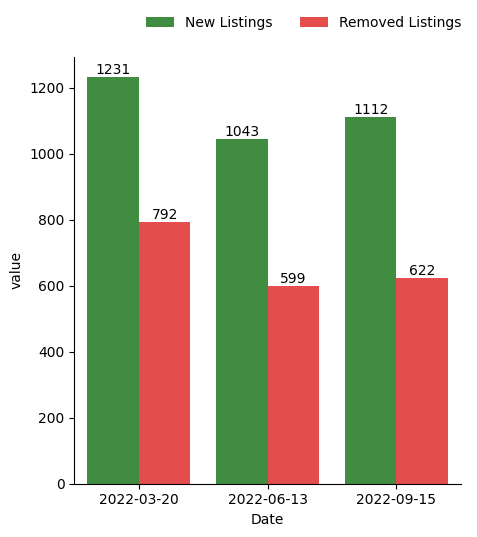

In [409]:
palette ={"New Listings": "green", "Removed Listings": "Red"}
g = sns.catplot(x = 'Date', y='value', 
                hue = 'Listing Status',palette = palette, data=df_deltas_new, 
                kind='bar', alpha=0.8)
sns.move_legend(
    g, "lower center",
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)
# annotate the bar chart                
for container in g.ax.containers:
    g.ax.bar_label(container)                

In [410]:
# Check for the NaN values in any column in the calendar df
df_calendar[df_calendar.isna().any(axis=1)]

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,scrape_date,available_num
1855344,3710914,2022-09-15,f,$169.00,$135.00,NaN,NaN,2022-09-15,0


In [411]:
# Check in the listings df for the min & max nights in df
df_listings[df_listings['id']==3710914][['host_id','minimum_nights','maximum_nights','last_scraped']]

,host_id,minimum_nights,maximum_nights,last_scraped
107,225274317,2,180,2021-12-17
6484,225274317,2,180,2022-03-20
13207,10259524,2,180,2022-06-13
20503,10259524,1,180,2022-09-16


In [412]:
# Imputing the missing values of minimum_night & maximum_night of listing_id = 3710914 of date - 2022-09-15 with minimum_night & maximum_night of listing file 
df_calendar.iloc[1855344,5:7] = [1,180]
df_calendar.iloc[1855344,:]

listing_id                   38602517
date              2022-11-10 00:00:00
available                           f
price                         $149.00
adjusted_price                $149.00
minimum_nights                    1.0
maximum_nights                  180.0
scrape_date                2022-09-15
available_num                       0
Name: 2443096, dtype: object

In [413]:
# Get the active listings (based on each day)
df_active_listings = df_calendar.groupby(['date'], as_index = False).agg({'listing_id' : pd.Series.nunique}).rename(columns={
    'listing_id': 'Active Listings'
})
df_active_listings

,date,Active Listings
0,2021-12-17,5751
1,2021-12-18,5751
2,2021-12-19,5751
3,2021-12-20,5751
4,2021-12-21,5751
...,...,...
375,2022-12-27,7257
376,2022-12-28,7257
377,2022-12-29,7257
378,2022-12-30,7257


<AxesSubplot: xlabel='date'>

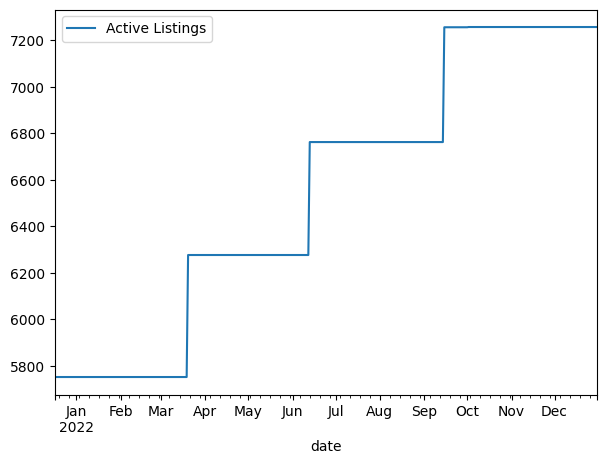

In [414]:
df_active_listings.plot.line( x = 'date' , y= 'Active Listings', figsize=(7, 5))

In [415]:
# Make bins based on the minimum nights for short/ lomg term rentals
# bins = 1 -3, 4-10, 11-32, 33 - 95 , 95 - 185 , 185-365, 366 and above
def assign_bin(min_nights):
    if min_nights < 4 :
        return 'Short-term rentals'
    elif min_nights < 11:
        return 'Weekly rentals'
    elif min_nights < 33:
        return 'Monthly rentals'
    elif min_nights < 95:
        return 'Quarterly rentals'
    elif min_nights < 185:
        return 'Semi-Annual rentals'
    elif min_nights < 366:
        return 'Yearly rentals'
    else:
        return 'Long-term rentals'

df_calendar['minimum_nights_bin'] = df_calendar['minimum_nights'].apply(assign_bin)
df_calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,scrape_date,available_num,minimum_nights_bin
1,3095791,2021-12-17,t,$80.00,$80.00,30.0,1125.0,2021-12-17,1,Monthly rentals
2,3095791,2021-12-18,t,$80.00,$80.00,30.0,1125.0,2021-12-17,1,Monthly rentals
3,3095791,2021-12-19,t,$60.00,$60.00,30.0,1125.0,2021-12-17,1,Monthly rentals
4,3095791,2021-12-20,t,$60.00,$60.00,30.0,1125.0,2021-12-17,1,Monthly rentals
5,3095791,2021-12-21,t,$60.00,$60.00,30.0,1125.0,2021-12-17,1,Monthly rentals


In [416]:
# Count the unique listing in minimum_nights_bin
df_rentals = df_calendar.groupby('minimum_nights_bin').agg({'listing_id' : pd.Series.nunique}).rename(columns = {
    'listing_id' : 'Rentals Count'
})
df_rentals.head(7)

,Rentals Count
minimum_nights_bin,
Long-term rentals,6
Monthly rentals,1239
Quarterly rentals,302
Semi-Annual rentals,11
Short-term rentals,7604
Weekly rentals,1543
Yearly rentals,6


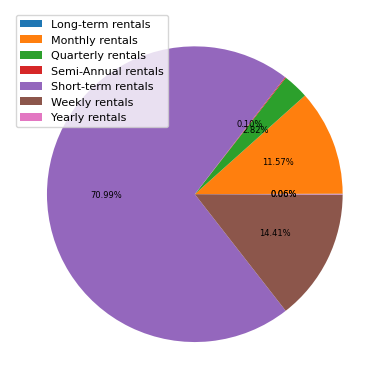

In [417]:
# df_rentals.plot.pie(y = 'Rentals Count', autopct='%.2f',legend=True,fontsize=8, sort_columns = True)
plt.pie(df_rentals['Rentals Count'], autopct='%.2f%%', textprops={'fontsize': 6})
plt.legend(df_rentals.index, loc="upper left", fontsize = 8)
plt.show()

**Median Price on weekday & weekends**

In [418]:
# Convert the price from object to float type
df_calendar['price_dollars'] = df_calendar['price'].replace('[\$,]', '', regex=True).astype(float)
df_calendar['price_dollars']

# Update the CSV
df_calendar.to_csv('calendar.csv', index=False)

In [419]:
# plot the median price
df_cal_median_price = df_calendar.groupby('date', as_index=False)['price_dollars'].agg(np.median)
df_cal_median_price['day_name'] = df_cal_median_price.date.dt.day_name()
df_cal_median_price.head()

,date,price_dollars,day_name
0,2021-12-17,199.0,Friday
1,2021-12-18,200.0,Saturday
2,2021-12-19,159.0,Sunday
3,2021-12-20,150.0,Monday
4,2021-12-21,150.0,Tuesday


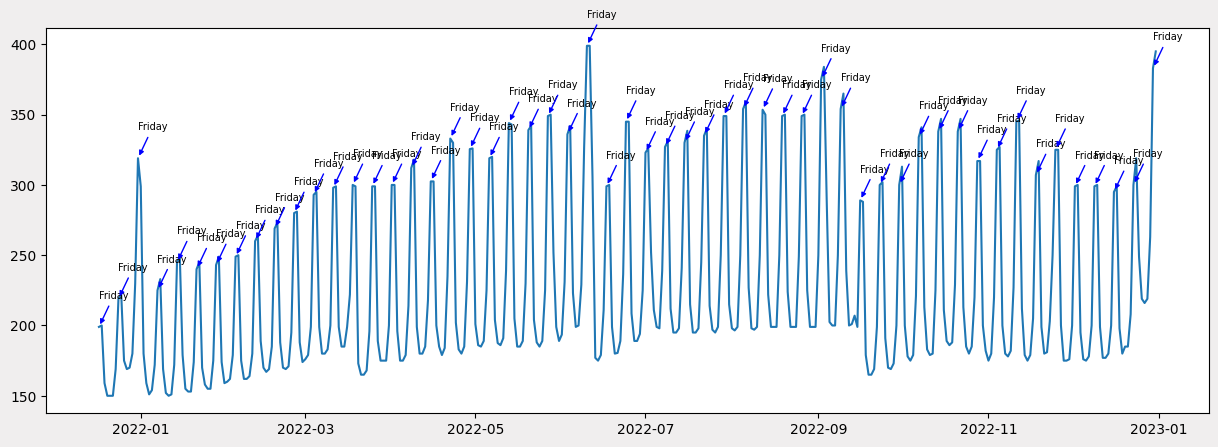

In [420]:
fig, ax = plt.subplots(facecolor='#f0eeee')
fig.set_size_inches(15, 5)
ax.plot('date', 'price_dollars', data = df_cal_median_price)

arrowprops=dict(arrowstyle='-|>', color='blue', linewidth=1)
for index, row in df_cal_median_price.iterrows():
    # print(row['day_name'])
    if row['day_name'] == 'Friday':
        ax.annotate('Friday',
                    xy = (row['date'], row['price_dollars']),
                    xytext=(row['date'], row['price_dollars'] +20), # text position (x, y)
                    arrowprops=arrowprops,
                    fontsize = 7)               

In [421]:
# plot the mean price
df_cal_mean_price = df_calendar.groupby('date', as_index=False)['price_dollars'].agg(np.mean)
df_cal_mean_price['day_name'] = df_cal_mean_price.date.dt.day_name()
df_cal_mean_price.head()

,date,price_dollars,day_name
0,2021-12-17,297.785950,Friday
1,2021-12-18,301.780734,Saturday
2,2021-12-19,220.740393,Sunday
3,2021-12-20,209.441662,Monday
4,2021-12-21,208.806990,Tuesday


In [422]:
df_calendar[df_calendar['price_dollars'] > 2000]['listing_id'].unique().shape

(466,)

Text(0, 0.5, 'Mean Price')

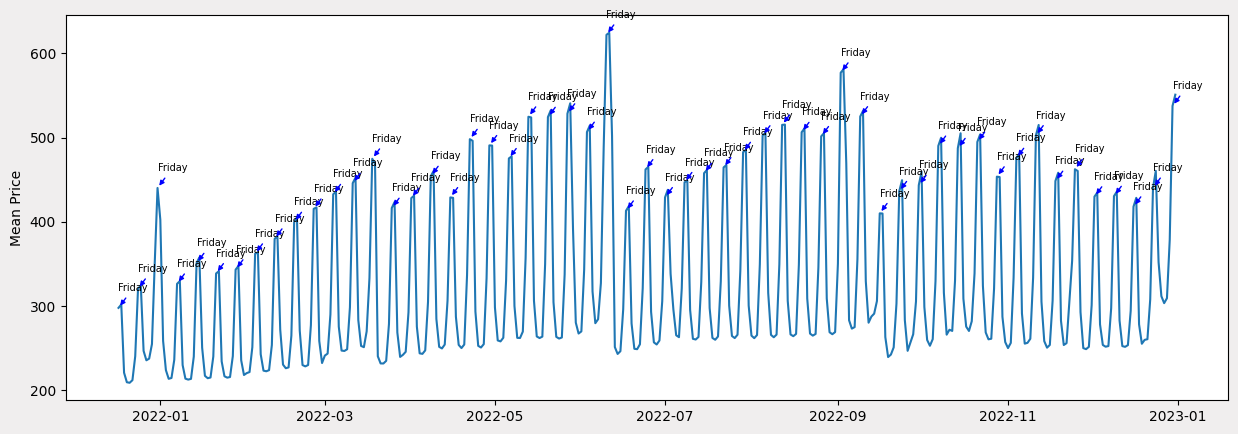

In [423]:
fig, ax = plt.subplots(facecolor='#f0eeee')
fig.set_size_inches(15, 5)
ax.plot('date', 'price_dollars', data = df_cal_mean_price)

arrowprops=dict(arrowstyle='-|>', color='blue', linewidth=1)
for index, row in df_cal_mean_price.iterrows():
    # print(row['day_name'])
    if row['day_name'] == 'Friday':
        ax.annotate('Friday',
                    xy = (row['date'], row['price_dollars']),
                    xytext=(row['date'], row['price_dollars'] +20), # text position (x, y)
                    arrowprops=arrowprops,
                    fontsize = 7)

ax.set_ylabel('Mean Price')

In [424]:
# plot the mean price (weekwise)
df_cal_mean_price_week = df_cal_mean_price.copy()
df_cal_mean_price_week['week'] = df_cal_mean_price_week['date'].dt.strftime('%Y-%W')
df_cal_mean_price_weekwise = df_cal_mean_price_week.groupby('week', as_index=False)['price_dollars'].agg([min, max])
annotation_weeks = {
    '2021-52': 'Christmas Week',
    '2022-00': 'New Year Week',
    '2022-21': 'Memorial Week',
    '2022-23': 'Juneteenth Week',
    '2022-26': 'Independence Week',
    '2022-35': 'Labor Week',
    '2022-45': 'Thanksgiving Week',
    '2022-51': 'Christmas Week',
}
for key, value in annotation_weeks.items():
    df_cal_mean_price_weekwise.loc[key, 'annotation'] = value

df_cal_mean_price_weekwise.reset_index(inplace=True)
df_cal_mean_price_weekwise.head()

,week,min,max,annotation
0,2021-50,220.740393,301.780734,NaN
1,2021-51,208.806990,324.386194,NaN
2,2021-52,235.497479,440.250739,Christmas Week
3,2022-00,258.553643,402.475222,New Year Week
4,2022-01,213.532255,329.634846,NaN


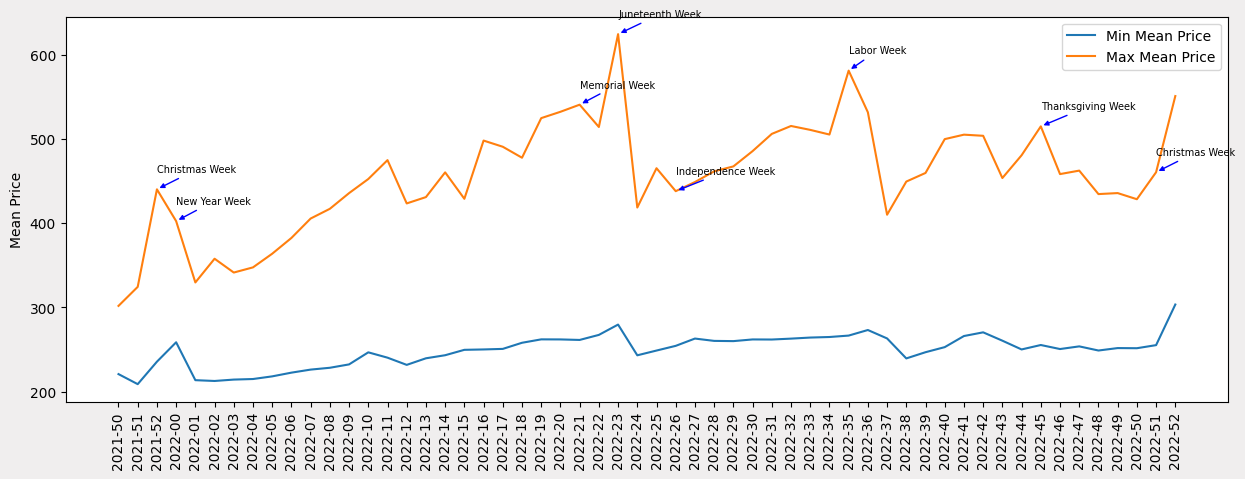

In [425]:
fig, ax = plt.subplots(facecolor='#f0eeee')
fig.set_size_inches(15, 5)
ax.plot('week', 'min', data = df_cal_mean_price_weekwise)
ax.plot('week', 'max', data = df_cal_mean_price_weekwise)
ax.set_ylabel('Mean Price')
ax.tick_params(axis='x', rotation=90)
ax.legend(['Min Mean Price', 'Max Mean Price'])
   
arrowprops=dict(arrowstyle='-|>', color='blue', linewidth=1)
for index, row in df_cal_mean_price_weekwise.iterrows():
    if not pd.isna(row['annotation']):
        ax.annotate(row['annotation'],
                    xy = (row['week'], row['max']),
                    xytext=(row['week'], row['max'] +20), # text position (x, y)
                    arrowprops=arrowprops,
                    fontsize = 7)

## Market Demand

**Occupancy Rate** - The percentage of listings occupied out of total listings

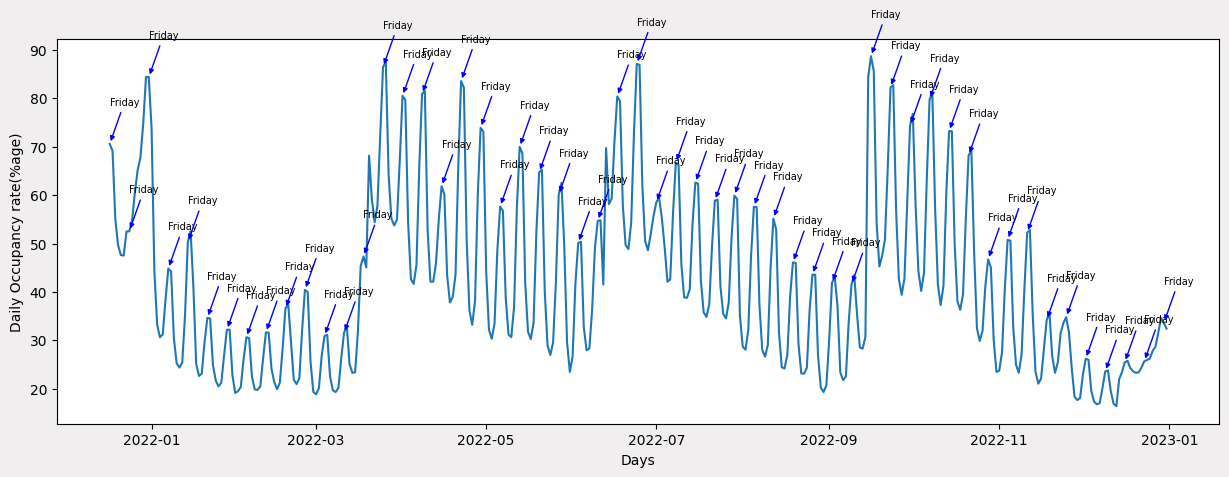

In [426]:
# Occupancy rate daily
df_occupancy_data = df_calendar.groupby(['date', 'available']).size().reset_index(name = 'count').pivot(index = 'date', columns = 'available', values = 'count').\
                                                                             rename(columns = {'f' : 'not_available_count' , 't' : 'available_count'})
df_occupancy_data['occupancy_rate'] = (df_occupancy_data['not_available_count'] * 100 )/ (df_occupancy_data['not_available_count'] + df_occupancy_data['available_count'] ) 
df_occupancy_data['day_name'] = df_occupancy_data.index.day_name() 
df_occupancy_data.reset_index(inplace=True)

fig, ax = plt.subplots(facecolor='#f0eeee')
fig.set_size_inches(15, 5)
ax.plot('date' , 'occupancy_rate',data = df_occupancy_data )

arrowprops=dict(arrowstyle='-|>', color='blue', linewidth=1)
for index, row in df_occupancy_data.iterrows():
    
    if row['day_name'] == 'Friday':
        ax.annotate('Friday',
                    xy = (row['date'], row['occupancy_rate']),
                    xytext=(row['date'], row['occupancy_rate'] + 8), # text position (x, y)
                    arrowprops=arrowprops,
                    fontsize = 7)
ax.set_xlabel('Days')                    
ax.set_ylabel('Daily Occupancy rate(%age)')    
plt.show()                

In [427]:
# Occupancy rate monthly
df_calendar_month = pd.DataFrame()
df_calendar_month['date'] = df_calendar['date']
df_calendar_month['year'] = df_calendar['date'].dt.year
df_calendar_month['month'] = df_calendar['date'].dt.month
df_calendar_month['available'] = df_calendar['available']

Text(0, 0.5, 'Occupancy Rate (%age)')

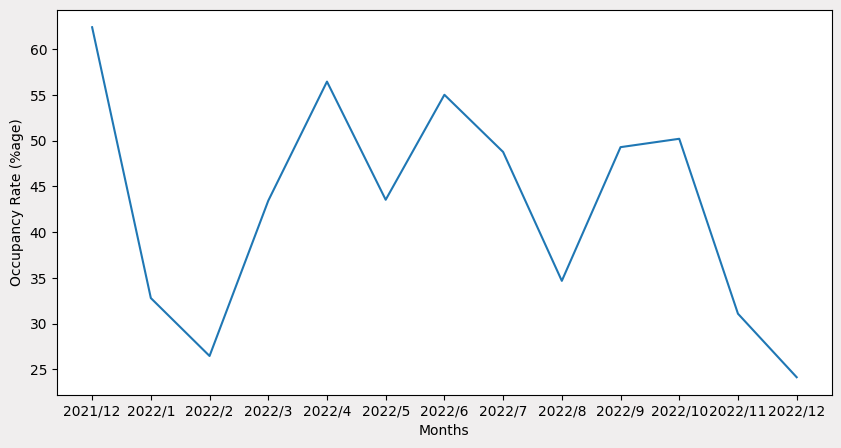

In [428]:
df_occupancy_data = df_calendar_month.groupby(['year','month', 'available']).size().reset_index(name = 'count').pivot(index = ['year', 'month'], columns = 'available', values = 'count').\
                                                                              rename(columns = {'f' : 'not_available_count' , 't' : 'available_count'})
df_occupancy_data.reset_index(inplace = True)

df_occupancy_data['occupancy_rate'] = (df_occupancy_data['not_available_count'] * 100) / (df_occupancy_data['not_available_count'] + df_occupancy_data['available_count'] ) 

df_occupancy_data['year_month'] = df_occupancy_data['year'].astype('string') + '/' + df_occupancy_data['month'].astype('string')

fig, ax = plt.subplots(facecolor='#f0eeee')
fig.set_size_inches(10, 5)
ax.plot('year_month' , 'occupancy_rate',data = df_occupancy_data )
ax.set_xlabel('Months')
ax.set_ylabel('Occupancy Rate (%age)')